<a href="https://colab.research.google.com/github/ManciniGa/Aprendizado-Profundo/blob/main/CHATBOT_Diploma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ChatBot - Diploma


---

O código apresentado é uma aplicação prática de reconhecimento óptico de caracteres (OCR) integrada ao processamento de imagens e análise de texto, utilizando ferramentas como Tesseract OCR, OpenCV, spaCy e pdf2image. Ele foi projetado para validar a presença de termos específicos em documentos, sejam imagens ou PDFs, permitindo o upload de arquivos, a conversão de PDFs em imagens e a detecção visual de palavras com base na confiança do OCR. Além de destacar os textos encontrados, o código desenha caixas ao redor das ocorrências e exibe as marcações diretamente no ambiente de execução, como o Google Colab. A aplicação combina processamento visual e análise de linguagem natural, sendo útil em tarefas como validação de documentos e extração automatizada de informações em múltiplos formatos.

^C
mkdir: cannot create directory ‘tessdata’: File exists
--2024-11-23 18:24:12--  https://github.com/tesseract-ocr/tessdata/blob/master/por.traineddata?raw=true
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/tesseract-ocr/tessdata/blob/main/por.traineddata [following]
--2024-11-23 18:24:12--  https://github.com/tesseract-ocr/tessdata/blob/main/por.traineddata
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘./tessdata/por.traineddata’

./tessdata/por.trai     [ <=>                ] 294.86K  --.-KB/s    in 0.02s   

2024-11-23 18:24:13 (18.7 MB/s) - ‘./tessdata/por.traineddata’ saved [301940]

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr-por is already the newest version (1:4.00~git30

Saving diploma.jpg to diploma (1).jpg
Digite o texto que deseja verificar na imagem: Diploma
Documento validado com sucesso! 'Diploma' encontrado 1 vez(es) na imagem.


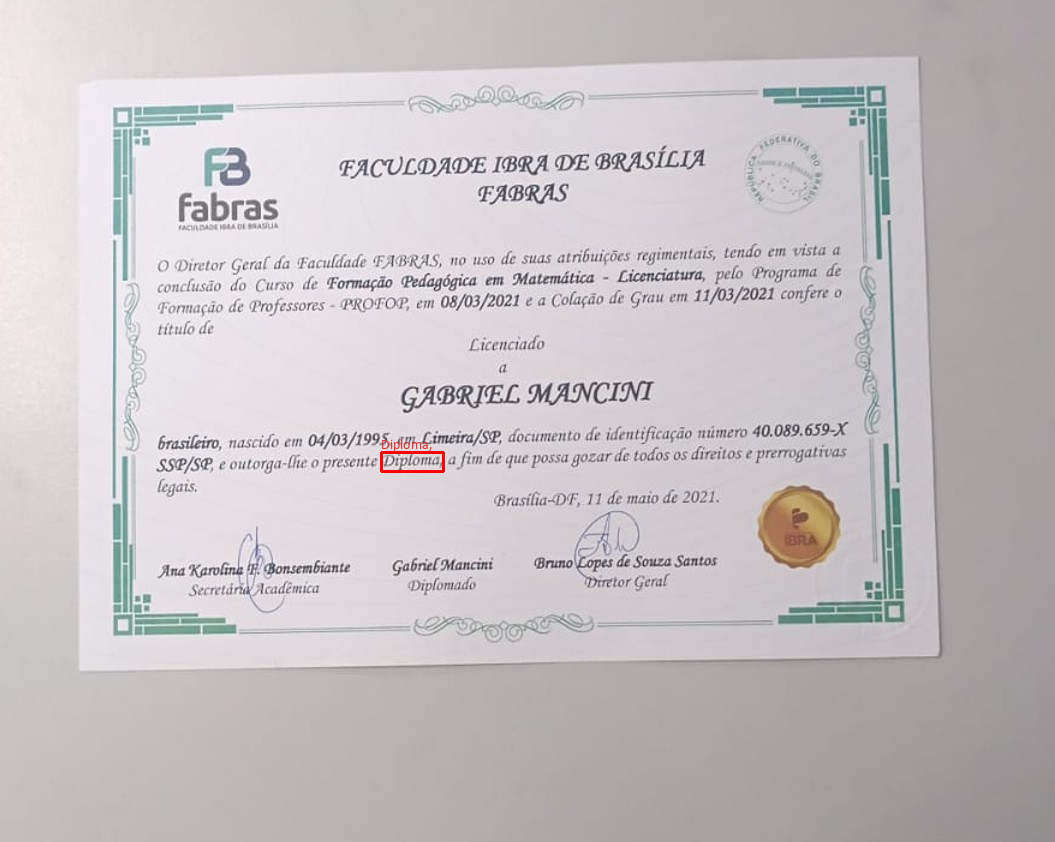

In [ ]:
# Instalações e configuração do Tesseract e dependências
# Instala o Tesseract OCR, uma ferramenta de reconhecimento óptico de caracteres
!sudo apt install tesseract-ocr
# Instala o pytesseract, uma biblioteca Python que interage com o Tesseract
!pip install pytesseract
# Instala o WordCloud, usado para criar nuvens de palavras
!pip install wordcloud
# Instala o spaCy, uma biblioteca para processamento de linguagem natural
!pip install spacy

# Baixar o modelo de linguagem para português
# Cria um diretório local para armazenar os dados de treinamento do Tesseract
!mkdir tessdata
# Baixa o modelo de linguagem do Tesseract para o idioma português
!wget -O ./tessdata/por.traineddata https://github.com/tesseract-ocr/tessdata/blob/master/por.traineddata?raw=true
# Instala o pacote de idioma português para o Tesseract
!apt-get install tesseract-ocr-por -y
# Faz o download do modelo de linguagem natural em português para o spaCy
!python -m spacy download pt_core_news_sm

# Imports necessários
# Importa as bibliotecas e funções que serão utilizadas no código
import pytesseract  # Interface Python para o Tesseract OCR
from pytesseract import Output  # Para manipulação detalhada da saída do Tesseract
import numpy as np  # Biblioteca para operações numéricas
import cv2  # OpenCV para manipulação de imagens
import os  # Para interações com o sistema operacional
import re  # Para expressões regulares
import matplotlib.pyplot as plt  # Para visualização de gráficos
from google.colab.patches import cv2_imshow  # Para exibir imagens no Google Colab
from PIL import ImageFont, ImageDraw, Image  # Manipulação de imagens e fontes
import spacy  # Processamento de linguagem natural
from wordcloud import WordCloud  # Para criar nuvens de palavras
from spacy import displacy  # Para visualização de entidades do spaCy
from google.colab import files  # Para upload de arquivos no Google Colab

# Configuração do OCR
# Define o caminho onde os dados de treinamento do Tesseract estão localizados
os.environ['TESSDATA_PREFIX'] = '/usr/share/tesseract-ocr/4.00/tessdata/'
# Configuração adicional para o Tesseract
config_tesseract = "/usr/share/tesseract-ocr/4.00/tessdata/"
# Carrega o modelo de linguagem natural do spaCy para português
pln = spacy.load('pt_core_news_sm')

# Função de exibição
# Exibe uma imagem no Google Colab
def mostrar(img):
    cv2_imshow(img)

# Função para executar OCR
# Extrai texto de uma imagem usando o Tesseract OCR
def OCR_processa(img, config_tesseract):
    texto = pytesseract.image_to_string(img, lang='por', config=config_tesseract)
    return texto

# Função para processar e detectar o termo
# Processa a imagem e verifica a presença de um termo específico
def OCR_processa_imagem(img, termo_pesquisa, config_tesseract, min_conf, fonte_dir):
    # Extrai dados detalhados do OCR, como posição e confiança
    resultado = pytesseract.image_to_data(img, config=config_tesseract, lang='por', output_type=Output.DICT)
    num_ocorrencias = 0  # Contador de ocorrências do termo
    for i in range(0, len(resultado['text'])):
        confianca = int(resultado['conf'][i])  # Nível de confiança do OCR
        if confianca > min_conf:
            texto = resultado['text'][i]  # Texto reconhecido
            if termo_pesquisa in texto:
                # Desenha uma caixa ao redor do texto encontrado e escreve o texto na imagem
                x, y, img = caixa_texto(i, resultado, img, (0, 0, 255))
                img = escreve_texto(texto, x, y, img, fonte_dir, (50, 50, 225), 14)
                num_ocorrencias += 1  # Incrementa o contador de ocorrências
    return img, num_ocorrencias

# Funções auxiliares para escrever texto e desenhar caixas
# Escreve texto em uma posição específica da imagem
def escreve_texto(texto, x, y, img, fonte_dir, cor=(50, 50, 255), tamanho=16):
    fonte = ImageFont.truetype(fonte_dir, tamanho)  # Define a fonte e o tamanho
    img_pil = Image.fromarray(img)  # Converte a imagem para o formato PIL
    draw = ImageDraw.Draw(img_pil)  # Ferramenta para desenhar na imagem
    draw.text((x, y-tamanho), texto, font=fonte, fill=cor)  # Escreve o texto
    img = np.array(img_pil)  # Converte de volta para o formato NumPy
    return img

# Desenha uma caixa ao redor do texto detectado
def caixa_texto(i, resultado, img, cor=(255, 100, 0)):
    x = resultado["left"][i]  # Coordenada x do texto
    y = resultado["top"][i]  # Coordenada y do texto
    w = resultado["width"][i]  # Largura da caixa
    h = resultado["height"][i]  # Altura da caixa
    cv2.rectangle(img, (x, y), (x + w, y + h), cor, 2)  # Desenha o retângulo
    return x, y, img

# Chatbot para validar texto em imagem
# Interage com o usuário para validar texto em imagens
def chatbot_validador():
    print("Bem-vindo ao validador de documentos!")

    # Upload da imagem
    print("Por favor, faça o upload da imagem que deseja validar.")
    uploaded = files.upload()  # Permite que o usuário faça o upload de arquivos

    # Carregar imagem e preparar OCR
    for imagem_nome in uploaded.keys():
        img = cv2.imread(imagem_nome)  # Carrega a imagem enviada
        if img is None:
            print(f"Erro ao carregar a imagem: {imagem_nome}")
            return

        # Perguntar ao usuário o termo a ser detectado
        termo_pesquisa = input("Digite o texto que deseja verificar na imagem: ")

        # Processar a imagem em busca do termo
        min_conf = 2  # Nível mínimo de confiança
        fonte_dir = '/content/calibri.ttf'  # Fonte para escrever na imagem

        img, num_ocorrencias = OCR_processa_imagem(img, termo_pesquisa, config_tesseract, min_conf, fonte_dir)

        # Exibir resultado para o usuário
        if num_ocorrencias > 0:
            print(f"Documento validado com sucesso! '{termo_pesquisa}' encontrado {num_ocorrencias} vez(es) na imagem.")
        else:
            print(f"Texto '{termo_pesquisa}' não encontrado na imagem.")

        # Exibir a imagem processada com as marcações
        mostrar(img)

# Executa o chatbot
chatbot_validador()

## para PDF

In [ ]:
# Instalações e configuração do Tesseract e dependências
# Instala o Tesseract OCR, uma ferramenta de código aberto para reconhecimento de texto em imagens
!sudo apt install tesseract-ocr

# Instala o pytesseract, uma interface Python que facilita o uso do Tesseract OCR
!pip install pytesseract

# Instala a biblioteca WordCloud, usada para criar representações visuais de frequência de palavras
!pip install wordcloud

# Instala o spaCy, uma biblioteca para processamento avançado de linguagem natural
!pip install spacy

# Instala o pdf2image, que permite converter páginas de um arquivo PDF em imagens
!pip install pdf2image

# Baixar o modelo de linguagem para português
# Cria um diretório chamado "tessdata" para armazenar os arquivos de modelo de linguagem do Tesseract
!mkdir tessdata

# Faz o download do modelo de linguagem "por.traineddata" para o idioma português
!wget -O ./tessdata/por.traineddata https://github.com/tesseract-ocr/tessdata/blob/master/por.traineddata?raw=true

# Instala suporte adicional para OCR em português no Tesseract
!apt-get install tesseract-ocr-por -y

# Baixa o modelo de linguagem natural em português para o spaCy, necessário para tarefas de PLN
!python -m spacy download pt_core_news_sm

# Imports necessários
# Importa pytesseract para realizar o OCR em imagens
import pytesseract

# Importa o módulo Output do pytesseract para trabalhar com a saída detalhada do OCR
from pytesseract import Output

# Importa a biblioteca numpy para manipulação de arrays numéricos
import numpy as np

# Importa OpenCV (cv2) para manipulação e processamento de imagens
import cv2

# Importa o módulo os para interações com o sistema operacional, como variáveis de ambiente
import os

# Importa a biblioteca re para trabalhar com expressões regulares
import re

# Importa matplotlib para visualização de gráficos
import matplotlib.pyplot as plt

# Importa a função cv2_imshow do Google Colab para exibição de imagens no ambiente Colab
from google.colab.patches import cv2_imshow

# Importa funcionalidades da biblioteca PIL para manipular imagens e fontes
from PIL import ImageFont, ImageDraw, Image

# Importa spaCy para processamento de linguagem natural
import spacy

# Importa a classe WordCloud para criar nuvens de palavras
from wordcloud import WordCloud

# Importa o módulo displacy do spaCy para visualização de entidades
from spacy import displacy

# Importa a função files do Google Colab para facilitar o upload de arquivos
from google.colab import files

# Importa a função convert_from_path do pdf2image para converter PDFs em imagens
from pdf2image import convert_from_path

# Configuração do OCR
# Configura o caminho do modelo de treinamento do Tesseract para que ele reconheça textos corretamente
os.environ['TESSDATA_PREFIX'] = '/usr/share/tesseract-ocr/4.00/tessdata/'

# Define a configuração adicional do Tesseract, especificando o caminho dos dados
config_tesseract = "/usr/share/tesseract-ocr/4.00/tessdata/"

# Carrega o modelo de linguagem natural em português para tarefas de PLN com spaCy
pln = spacy.load('pt_core_news_sm')

# Função de exibição
# Função para exibir uma imagem no ambiente do Google Colab
def mostrar(img):
    cv2_imshow(img)  # Usa cv2_imshow para exibir a imagem no formato apropriado

# Função para executar OCR
# Extrai o texto de uma imagem usando o Tesseract OCR
def OCR_processa(img, config_tesseract):
    texto = pytesseract.image_to_string(img, lang='por', config=config_tesseract)  # Extrai texto na língua portuguesa
    return texto  # Retorna o texto extraído

# Função para processar e detectar o termo
# Processa uma imagem em busca de um termo específico, aplicando OCR e desenhando caixas de marcação
def OCR_processa_imagem(img, termo_pesquisa, config_tesseract, min_conf, fonte_dir):
    # Usa pytesseract para obter detalhes do texto detectado, como posição, dimensão e confiança
    resultado = pytesseract.image_to_data(img, config=config_tesseract, lang='por', output_type=Output.DICT)
    num_ocorrencias = 0  # Inicializa o contador de ocorrências do termo

    # Itera sobre cada palavra detectada pelo OCR
    for i in range(0, len(resultado['text'])):
        confianca = int(resultado['conf'][i])  # Obtém o nível de confiança da palavra
        if confianca > min_conf:  # Filtra palavras com nível de confiança acima do mínimo
            texto = resultado['text'][i]  # Obtém o texto reconhecido
            if termo_pesquisa in texto:  # Verifica se o termo pesquisado está no texto detectado
                # Adiciona uma caixa ao redor do texto detectado na imagem
                x, y, img = caixa_texto(i, resultado, img, (0, 0, 255))
                # Escreve o texto detectado próximo à posição do termo na imagem
                img = escreve_texto(texto, x, y, img, fonte_dir, (50, 50, 225), 14)
                num_ocorrencias += 1  # Incrementa o contador de ocorrências
    return img, num_ocorrencias  # Retorna a imagem processada e o número de ocorrências

# Funções auxiliares para escrever texto e desenhar caixas
# Escreve texto sobre a imagem na posição especificada
def escreve_texto(texto, x, y, img, fonte_dir, cor=(50, 50, 255), tamanho=16):
    fonte = ImageFont.truetype(fonte_dir, tamanho)  # Carrega a fonte e define o tamanho
    img_pil = Image.fromarray(img)  # Converte a imagem do formato NumPy para PIL
    draw = ImageDraw.Draw(img_pil)  # Cria um objeto de desenho na imagem
    draw.text((x, y-tamanho), texto, font=fonte, fill=cor)  # Escreve o texto na imagem
    img = np.array(img_pil)  # Converte a imagem de volta para o formato NumPy
    return img  # Retorna a imagem com o texto escrito

# Desenha uma caixa ao redor do texto detectado
def caixa_texto(i, resultado, img, cor=(255, 100, 0)):
    x = resultado["left"][i]  # Coordenada x do canto superior esquerdo da caixa
    y = resultado["top"][i]  # Coordenada y do canto superior esquerdo da caixa
    w = resultado["width"][i]  # Largura da caixa
    h = resultado["height"][i]  # Altura da caixa
    cv2.rectangle(img, (x, y), (x + w, y + h), cor, 2)  # Desenha o retângulo na imagem
    return x, y, img  # Retorna as coordenadas e a imagem processada

# Chatbot para validar texto em imagem ou PDF
# Função principal que interage com o usuário para validar documentos
def chatbot_validador():
    print("Bem-vindo ao validador de documentos!")

    # Solicita ao usuário que faça o upload do documento
    print("Por favor, faça o upload da imagem ou PDF que deseja validar.")
    uploaded = files.upload()  # Permite o upload de arquivos pelo usuário

    # Pergunta ao usuário o termo que deseja buscar no documento
    termo_pesquisa = input("Digite o texto que deseja verificar no documento: ")

    # Processa cada arquivo carregado
    for arquivo_nome in uploaded.keys():
        # Verifica se o arquivo é um PDF
        if arquivo_nome.lower().endswith('.pdf'):
            print(f"Processando PDF: {arquivo_nome}")

            # Converte as páginas do PDF em imagens
            paginas = convert_from_path(arquivo_nome)
            total_ocorrencias = 0  # Contador total de ocorrências no PDF

            # Itera por cada página convertida em imagem
            for i, pagina in enumerate(paginas):
                img = np.array(pagina)  # Converte a imagem de PIL para NumPy
                # Realiza OCR na página e busca o termo
                img, num_ocorrencias = OCR_processa_imagem(img, termo_pesquisa, config_tesseract, min_conf=2, fonte_dir='/content/calibri.ttf')
                total_ocorrencias += num_ocorrencias  # Soma as ocorrências da página

                # Exibe as marcações na página processada
                print(f"Página {i + 1}: Encontradas {num_ocorrencias} ocorrências de '{termo_pesquisa}'")
                mostrar(img)

            # Exibe o resumo das ocorrências no PDF
            if total_ocorrencias > 0:
                print(f"Documento validado com sucesso! '{termo_pesquisa}' encontrado {total_ocorrencias} vez(es) no PDF.")
            else:
                print(f"Texto '{termo_pesquisa}' não encontrado no PDF.")

        else:
            # Caso seja uma imagem, carrega o arquivo e realiza OCR
            img = cv2.imread(arquivo_nome)
            if img is None:
                print(f"Erro ao carregar o arquivo: {arquivo_nome}")
                return

            # Processa a imagem em busca do termo
            img, num_ocorrencias = OCR_processa_imagem(img, termo_pesquisa, config_tesseract, min_conf=2, fonte_dir='/content/calibri.ttf')

            # Exibe o resultado da validação para a imagem
            if num_ocorrencias > 0:
                print(f"Documento validado com sucesso! '{termo_pesquisa}' encontrado {num_ocorrencias} vez(es) na imagem.")
            else:
                print(f"Texto '{termo_pesquisa}' não encontrado na imagem.")

            # Mostra a imagem processada com as marcações
            mostrar(img)

# Executa o chatbot
chatbot_validador()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
mkdir: cannot create directory ‘tessdata’: File exists
--2024-11-17 23:29:18--  https://github.com/tesseract-ocr/tessdata/blob/master/por.traineddata?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/tesseract-ocr/tessdata/blob/main/por.traineddata [following]
--2024-11-17 23:29:18--  https://github.com/tesseract-ocr/tessdata/blob/main/por.traineddata
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘./tessdata/por.traineddata’

./tessdata/por.trai     [ <=>                ] 294.44K  --.-KB/s    in 0.02s   

2024-11-17 23:29

Saving Diploma_p.pdf to Diploma_p (1).pdf
Digite o texto que deseja verificar no documento: licenciatura
Processando PDF: Diploma_p (1).pdf


PDFInfoNotInstalledError: Unable to get page count. Is poppler installed and in PATH?